# Cervical Spine Fracture Detection
This notebook aims at building a deep learning pipeline to identify the fractures in the segmentation slices of the images of the CT-scans of the cervical spine and classify them into No frac, C1-C7 and Thoracic frac, i.e., 9 categories with the respective probabilities of having a fracture. 
We will employ various python libraries such as matplotlib, numpy and Google's Tensorflow DL framework for this notebook as it also supports Keras.

**NOTE:** The dataset contains additional data such as bounding boxes which will be useful in building more robust models but we are not going to utilize that for this notebook. However, we will be using only images whose segmentations are available for our use.

### 1. Problem
To build an end-to-end multilabel image classifier which can classify the images of fractures in No frac, C1-C7, thoracic frac with respective probabilities.

### 2. Data
The data we're using is from Kaggle's RSNA 2k22 Cervical Spine Fracture Detection competition. For more information...  
https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/data

### 3. Evaluation
The evaluation metric for the predictions is binary weighted log loss function. It is the ratio of predictions our model got right and the total predictions made.

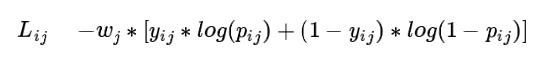

For more information...https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/overview

## 1. Import Libraries, Dependencies and Dataset

It is given in the description that some of the DICOM files are JPEG compressed. So, we will require extra resources to read the pixel array of these files, such as GDCM and pylibjpeg. Hence, we will install this dependencies

In [7]:
!pip install python-gdcm
!pip install pylibjpeg

In [8]:
import os 
import re
import gc
import cv2
import pathlib
import glob 
import random
from tqdm import tqdm 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
import nibabel as nib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, callbacks, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3, DenseNet121, EfficientNetB7, Xception
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image as im

In [9]:
## Parameters
EPOCHS = 50
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
SEED = 11
# set seed
np.random.seed(SEED)
tf.random.set_seed(SEED)
root_dir = "../input/rsna-2022-cervical-spine-fracture-detection"

## 2. Data Loading and Visualization

* **NIFTI files** -> NIfTI (Neuroimaging Informatics Technology Initiative) is a data format for the storage of Functional Magnetic Resonance Imaging (fMRI) and other medical images.) 
* It consist of **segmentation in the sagittal plane**, while the **DICOM files** are in the **axial plane**.

In [10]:
# Load segmented images with mask
seg_paths = glob.glob(f"{root_dir}/segmentations/*")
# Get patient with available mask
training_patient=[]
for path in seg_paths:
    training_patient.append((path.rsplit("/",1)[-1])[:-4])

In [11]:
# No. of unique patients with available masks
len(np.unique(training_patient))

87

In [12]:
# Function to load segmentations
def load_NIfTI(path):
    mask = nib.load(path)
    
    # Convert to numpy array
    seg = mask.get_fdata()
    
    # Align orientation with DICOM images
    seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
    
    return seg

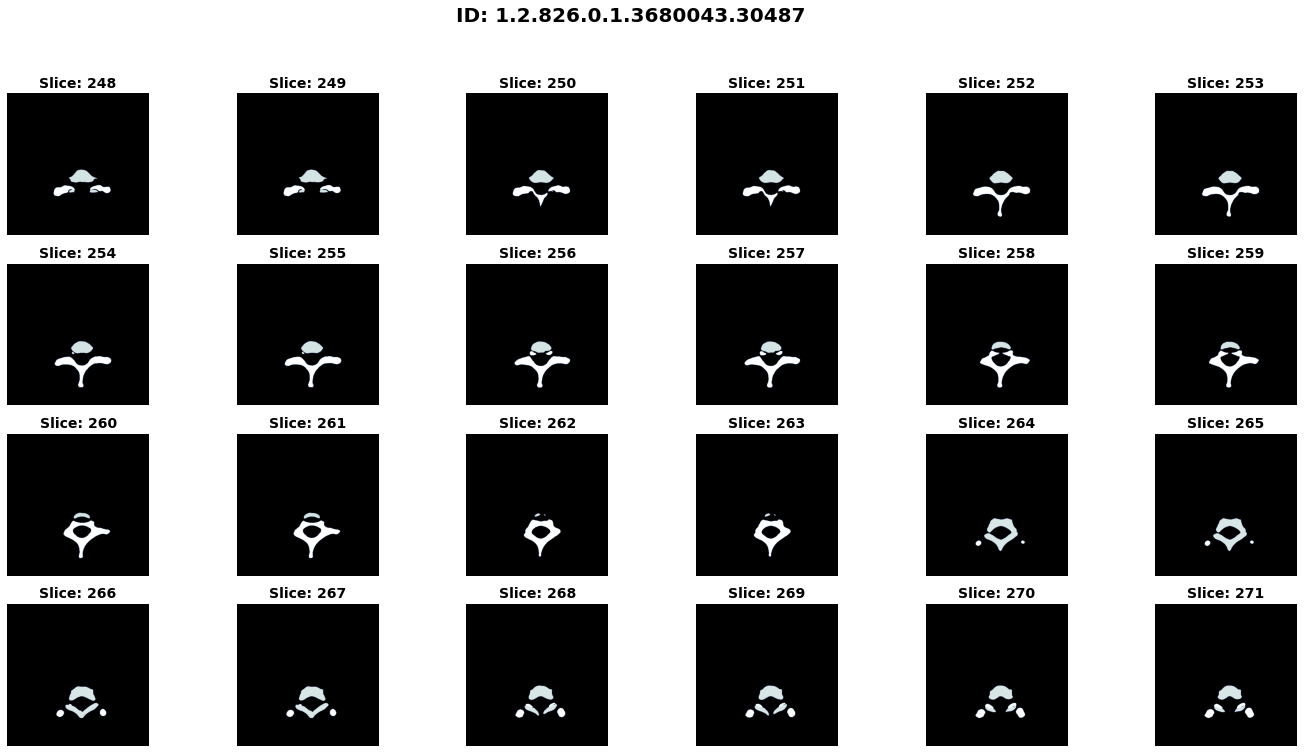

In [13]:
# Load and visualize the image segments for a random patientID
sample_patient_id = random.sample(training_patient, 1)[0]
sample_mask = f"{root_dir}/segmentations/{sample_patient_id}.nii"
patient_mask = load_NIfTI(sample_mask)
# print(patient_mask.shape)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {sample_patient_id}', weight="bold", size=20)

start=patient_mask.shape[0]-100
for i in range(start,start+24):
    mask = patient_mask[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='bone')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

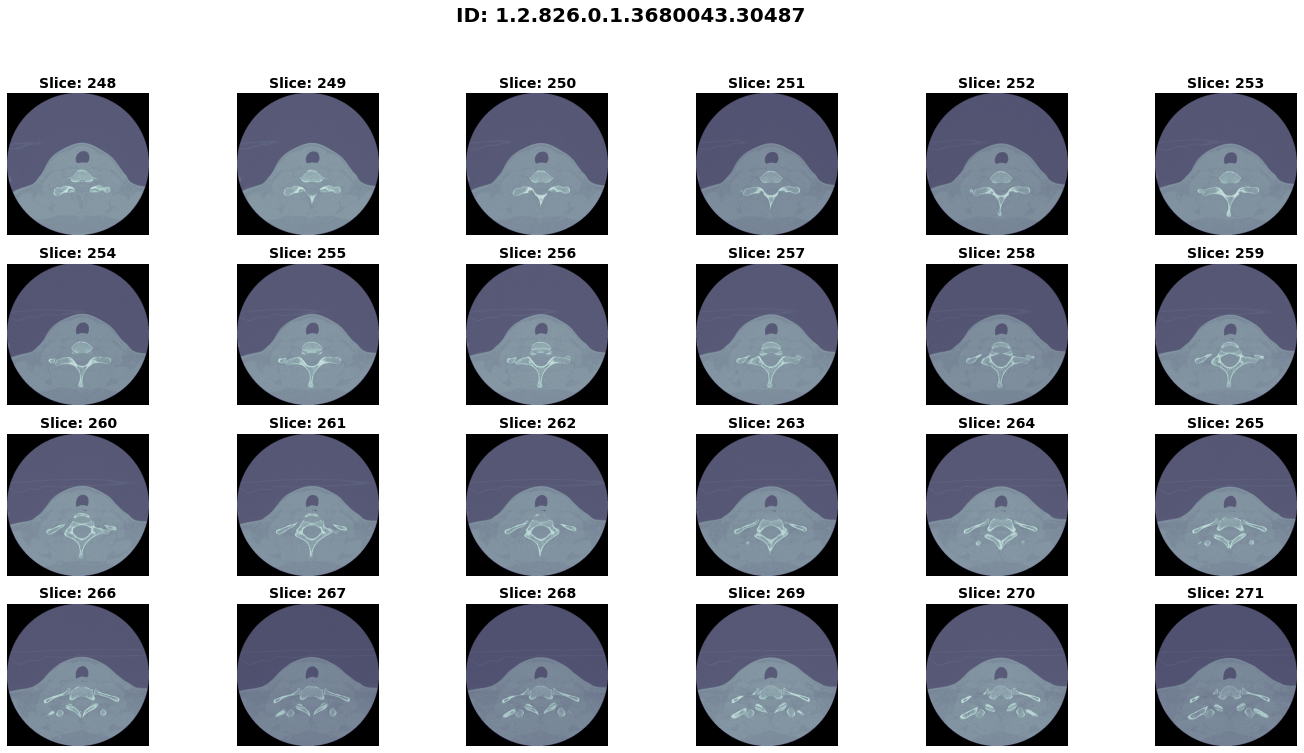

In [14]:
#Loading Scans
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# Function to load DICOM images
def load_scan(path):  
    dcm_paths = glob.glob(f"{path}/*")
    dcm_paths.sort(key=natural_keys)
    patient_scan = [pydicom.dcmread(paths) for paths in dcm_paths]
    return patient_scan

# Comparing the segmentation with the original images
sample_img_org_path = f"{root_dir}/train_images/{sample_patient_id}"
image = load_scan(sample_img_org_path)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {sample_patient_id}', weight="bold", size=20)

start=patient_mask.shape[0]-100
for i in range(start, start+24):
    mask = image[i].pixel_array
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='bone')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

## 3. Image pre-processing

### 3.1. Convert to HU scale

* The Hounsfield Unit (HU) scale, also known as CT (Computed Tomography) numbers or CT attenuation values, is a scale used in medical imaging to express the radiodensity of tissues observed on a CT scan.

* The scale is calibrated using water as a reference, which is assigned a value of 0 HU. Tissues with lower radiodensity than water (such as air) have negative values, while tissues with higher radiodensity (such as bone) have positive values.

In [15]:
def get_pixels_hu(slices):
    image = np.stack([cv2.resize(s.pixel_array,(128, 128),interpolation = cv2.INTER_NEAREST) for s in slices])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0, the intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    # Convert to Hounsfield units (HU)    
    intercept = np.array([slices[slice_number].RescaleIntercept for slice_number in range(len(slices))])
    slope = np.array([slices[slice_number].RescaleSlope for slice_number in range(len(slices))])
    intercept=intercept.reshape((-1,1,1))
    slope=slope.reshape((-1,1,1))
    image= (slope * image.astype("float64")) + intercept
     
    return image.astype("int16")

In [16]:
patient_slice = get_pixels_hu(image)
patient_slice[start].flatten().shape

(16384,)

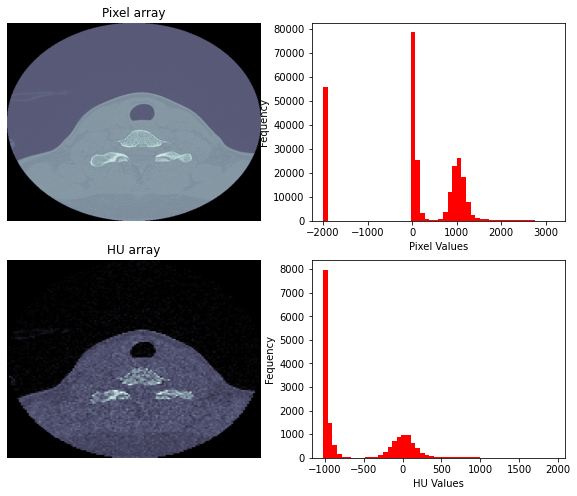

In [17]:
plt.figure(figsize=(10, 8))
# Ploting pixel array
plt.subplot(2, 2, 1)
plt.imshow(image[start].pixel_array,cmap='bone', aspect='auto')
plt.title('Pixel array')
plt.axis("off")

# Ploting pixel array distribution
plt.subplot(2, 2, 2)
plt.hist(image[start].pixel_array.flatten(),color="r",bins=50)
# plt.title('Pixel array distribution')
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")

#Ploting HU array
plt.subplot(2, 2, 3)
plt.imshow(patient_slice[start],cmap='bone', aspect='auto')
plt.title('HU array')
plt.axis("off")

# Ploting HU distribution
plt.subplot(2, 2, 4)
plt.hist(patient_slice[start].flatten(),color="r",bins=50)
# plt.title('HU distribution')
plt.xlabel("HU Values")
plt.ylabel("Fequency")
plt.show()

### 3.2. Image Normalization
As HU values range from **150** to **2050**. So we will use this values for normalization.

In [18]:
# Normalize the image pixels
MIN_BOUND = 150.0
MAX_BOUND = 2050.0

# Function to normalize the image pixels
def normalize(image):
    image = (image - MIN_BOUND)*255.0 / (MAX_BOUND - MIN_BOUND)
    image[image>255] = 255.
    image[image<0] = 255.
    image = image/255.
    return image

83644

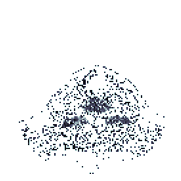

In [19]:
normalized_patient_slice = normalize(patient_slice)
plt.figure(figsize=(3, 4))
plt.imshow(normalized_patient_slice[start],cmap="bone")
plt.axis("off")

# Delete all unused objects to free up memory
del patient_slice
del image
gc.collect()

## 4. Modelling

In [20]:
# Split data into train and test set
train, val = train_test_split(training_patient, train_size=70, test_size=17, shuffle=True, random_state=SEED)
len(train), len(val)

(70, 17)

In [21]:
# Segregate the preprocessed image in these folders based on Segmentation data in Training Folder.
def segregate_train(start):
    X_train=[]
    y_train=[]
    for i in range(start, start+10):
        patient_ID = train[i]
        # Load segmentation for patientID
        patient_seg = load_NIfTI(f"{root_dir}/segmentations/{patient_ID}.nii")
#         print(patient_seg)
        # Load image for patientID
        patient_scan = load_scan(f"{root_dir}/train_images/{patient_ID}")
        # Convert to HU scale and normalize
        patient_hu = get_pixels_hu(patient_scan)
        patient_hu_normalised = normalize(patient_hu)
#         print(patient_hu_normalised)
        # Load segmentation slices
        for j in tqdm(range(len(patient_seg))):
            # Get the position of fracture
            # 0 -> no fracture
            # 1-7 -> position of cervical fracture
            # 8 -> elsewhere, i.e., thoracic fracture
#             print(patient_seg[j])
            classes = np.unique(patient_seg[j])
#             print(classes)
            temp_lables = np.zeros(9)
            
            for k in classes:
                if int(k)!=0:
                    if int(k)<8:
                        temp_lables[int(k)] = 1
                    else:
                        temp_lables[8] = 1
            
            frac = False
            for i in temp_lables:
                if i == 1:
                    frac = True
            
            if not frac:
                temp_lables[0]=1
            
            X_train.append(patient_hu_normalised[j].astype(np.uint8))
            y_train.append(temp_lables.astype(np.uint8))
        
    return X_train,y_train

In [22]:
# Segregate the preprocessed image in these folders based on Segmentation data in Training Folder.
def segregate_val():
    X_val=[]
    y_val=[]
    for i in range(0, 3):
        patient_ID = val[i]
        # Load segmentation for patientID
        patient_seg = load_NIfTI(f"{root_dir}/segmentations/{patient_ID}.nii")
#         print(patient_seg)
        # Load image for patientID
        patient_scan = load_scan(f"{root_dir}/train_images/{patient_ID}")
        # Convert to HU scale and normalize
        patient_hu = get_pixels_hu(patient_scan)
        patient_hu_normalised = normalize(patient_hu)
#         print(patient_hu_normalised)
        # Load segmentation slices
        for j in tqdm(range(0,len(patient_seg))):
            # Get the position of fracture
            # 0 -> no fracture
            # 1-7 -> position of cervical fracture
            # 8 -> elsewhere, i.e., thoracic fracture
            classes = np.unique(patient_seg[j])
            print(patient_seg[j])
            print(classes)
            temp_lables=np.zeros(9)
            for k in classes:
                if int(k)!=0:
                    if int(k)<8:
                        temp_lables[int(k)]=1
                    else:
                        temp_lables[8]=1
            
            frac = False
            for i in temp_lables:
                if i == 1:
                    frac = True
            
            if not frac:
                temp_lables[0]=1
                
            X_val.append(patient_hu_normalised[j].astype(np.uint8))
            y_val.append(temp_lables.astype(np.uint8))
        
    return X_val,y_val

In [23]:
# Call this in a loop to train the model in folds
X_train, y_train = segregate_train(0)
X_val, y_val = segregate_val()

  7%|▋         | 18/242 [00:00<00:01, 173.74it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0

 22%|██▏       | 54/242 [00:00<00:01, 170.21it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0.

 37%|███▋      | 89/242 [00:00<00:00, 167.70it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2.]
[[0. 0. 0. ... 0

 51%|█████     | 123/242 [00:00<00:00, 163.09it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3. 4.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3. 4.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3. 4.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3. 4.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3. 4.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3. 4.

 65%|██████▍   | 157/242 [00:00<00:00, 162.03it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5.

 79%|███████▉  | 191/242 [00:01<00:00, 163.73it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0.

 94%|█████████▍| 227/242 [00:01<00:00, 168.04it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8. 9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 8. 9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 8. 9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 0.  8.  9. 10.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 0.  8.  9. 10.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 

100%|██████████| 242/242 [00:01<00:00, 166.48it/s]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 0.  9. 10. 11.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 0.  9. 10. 11.]


 11%|█         | 18/164 [00:00<00:00, 170.63it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0

 32%|███▏      | 53/164 [00:00<00:00, 168.09it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.

 53%|█████▎    | 87/164 [00:00<00:00, 166.85it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 3. 4.]
[[0. 0. 0. ..

 74%|███████▍  | 121/164 [00:00<00:00, 168.03it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.

100%|██████████| 164/164 [00:00<00:00, 166.58it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8. 9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8. 9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.


  6%|▌         | 18/296 [00:00<00:01, 170.41it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0

 18%|█▊        | 53/296 [00:00<00:01, 152.48it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0

 29%|██▉       | 86/296 [00:00<00:01, 155.19it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[

 41%|████      | 120/296 [00:00<00:01, 162.36it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2.

 52%|█████▏    | 155/296 [00:00<00:00, 166.40it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2. 3.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2. 3.

 64%|██████▍   | 189/296 [00:01<00:00, 164.48it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 4. 5.

 75%|███████▌  | 223/296 [00:01<00:00, 150.74it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 5. 6.

 87%|████████▋ | 258/296 [00:01<00:00, 159.89it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 6. 7.

100%|██████████| 296/296 [00:01<00:00, 160.67it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 7. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 8.]
[[0. 0. 0.

In [24]:
# Lengths of train and test split
len(X_train), len(X_val), len(y_train), len(y_val)

(3520, 702, 3520, 702)

In [25]:
# Convert into specific format from tensorflow model
X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)
print(f"Train data shape: {X_train.shape}")
print(f"Train label shape: {y_train.shape}")
print(f"Val data shape: {X_val.shape}")
print(f"Val label shape: {y_val.shape}")

# Add the extra axis to the data
X_train = np.reshape(X_train, (-1,128,128,1))
X_val = np.reshape(X_val, (-1,128,128,1))
print(f"Train data shape after adding axis: {X_train.shape}")
print(f"Val data shape after adding axis: {X_val.shape}")

Train data shape: (3520, 128, 128)
Train label shape: (3520, 9)
Val data shape: (702, 128, 128)
Val label shape: (702, 9)
Train data shape after adding axis: (3520, 128, 128, 1)
Val data shape after adding axis: (702, 128, 128, 1)


In [26]:
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [28]:
def metrics(y_test, y_pred_binary):
    '''
    Function to display accuracy, precision, recall and f1-score for the classification task.
    
    Parameters:
    y_test: True labels.
    y_pred_binary: Predicted binary labels.

    Returns:
    Pandas dataframe containing class-wise Sensitivity, Specificity, and F1-score.
    
    '''
    classes = ['No frac','C1','C2','C3','C4','C5','C6','C7','Thoracic']
    df_res = []
    precision_per_class = precision_score(y_test, y_pred_binary, average=None)
    recall_per_class = recall_score(y_test, y_pred_binary, average=None)
    f1_per_class = f1_score(y_test, y_pred_binary, average=None)

    for i in range(len(classes)):
        df_res.append([classes[i], recall_per_class[i], precision_per_class[i], f1_per_class[i]])
    df_res = pd.DataFrame(df_res, columns = ['Class','Sensitivity','Specificity', 'F1-score'])
    return df_res

def plot_history(history):
    '''
    Function to plot the train and validation accuracy and loss.
    
    Parameters:
    history: model train history

    Returns:
    None.
    
    '''
    hist = history.history
    plt.figure(figsize=(8, 4));
    plt.suptitle(f"Performance Metrics", fontsize=12)

    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve', fontsize=8)
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['binary_accuracy'], label='train')
    plt.plot(hist['val_binary_accuracy'], label='validation')
    plt.title('Train and val accuracy curve', fontsize=8)
    plt.legend();

def callback(model_name):
    '''
    Function to define callback for model training.
    
    Parameters:
    model_name(string): Name for the saved model with `.h5` extension.

    Returns:
    [Early Stopping Callback, Model Checkpoint Callback]
    
    '''
    early_stopping = callbacks.EarlyStopping(patience=11, restore_best_weights=True)
    model_checkpoint = callbacks.ModelCheckpoint(model_name, save_best_only=True)
    return [early_stopping, model_checkpoint]

### 4.1. CNN model

In [21]:
#Defining the model
model_1 = tf.keras.Sequential([
    layers.Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (512,512,1)),
    layers.Conv2D(filters = 8, kernel_size = (3,3), activation ='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.30),
    layers.Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same', activation ='relu'),
    layers.Conv2D(filters = 8, kernel_size = (5,5), activation ='relu'),
    layers.MaxPool2D(pool_size=(4, 4)),
    layers.Dropout(0.30),
    layers.Conv2D(filters = 8, kernel_size = (7,7),padding = 'Same', activation ='relu'),
    layers.Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
    layers.MaxPool2D(pool_size=(6, 6)),
    layers.Dropout(0.30),
    layers.Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    layers.Conv2D(filters = 16, kernel_size = (7,7), activation ='relu'),
    layers.MaxPool2D(pool_size=(3, 3)),
    layers.Dropout(0.30),
    layers.Flatten(),
#     layers.Dense(12,activation="ReLU"),
    layers.Dense(9, activation='sigmoid')
])
model_1.build([None, 512, 512, 1])

# Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 510, 510, 8)       4616      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 255, 255, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 255, 255, 64)      25152     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 251, 251, 8)       12808     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 8)         0

In [22]:
# Train the model
history_model_1 = model_1.fit(datagen.flow(X_train,y_train),
                              validation_data=(X_val,y_val),
                              epochs=EPOCHS,
                              use_multiprocessing=True,
                              shuffle=True,
                              callbacks=callback("CNN_cervical_spine_model_1.h5"))

Epoch 1/50
110/110 [==============================] - 76s 590ms/step - loss: 0.5880 - binary_accuracy: 0.7121 - val_loss: 0.6073 - val_binary_accuracy: 0.8116
Epoch 2/50
110/110 [==============================] - 70s 631ms/step - loss: 0.5572 - binary_accuracy: 0.7452 - val_loss: 0.5982 - val_binary_accuracy: 0.8116
Epoch 3/50
110/110 [==============================] - 71s 645ms/step - loss: 0.5445 - binary_accuracy: 0.7564 - val_loss: 0.5854 - val_binary_accuracy: 0.8116
Epoch 4/50
110/110 [==============================] - 70s 630ms/step - loss: 0.5317 - binary_accuracy: 0.7638 - val_loss: 0.5253 - val_binary_accuracy: 0.8116
Epoch 5/50
110/110 [==============================] - 70s 636ms/step - loss: 0.5148 - binary_accuracy: 0.7736 - val_loss: 0.4699 - val_binary_accuracy: 0.8151
Epoch 6/50
110/110 [==============================] - 71s 642ms/step - loss: 0.4983 - binary_accuracy: 0.7794 - val_loss: 0.4727 - val_binary_accuracy: 0.8115
Epoch 7/50
110/110 [==========================

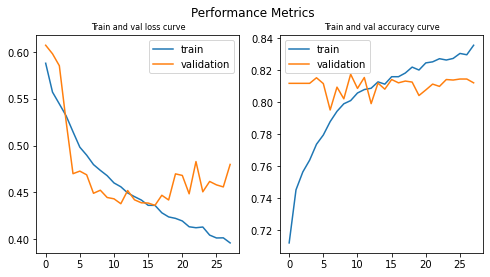

In [26]:
# Visualize train and validation accuracy and loss for model_1
plot_history(history_model_1);

In [29]:
# Get the class-wise scores on the test data
y_pred_1 = model_1.predict(X_val)
threshold = 0.4
y_pred_binary_1 = (y_pred_1 > threshold).astype(int)
score_1 = model_1.evaluate(X_val, y_val, verbose = 1)
df_met_model_1 = metrics(y_val, y_pred_binary_1)
print(f'Test loss:{score_1[0]}\n Test accuracy:{score_1[1]}')
df_met_model_1

22/22 [==============================] - 2s 76ms/step - loss: 0.4361 - binary_accuracy: 0.8120
Test loss:0.43607261776924133
 Test accuracy:0.811965823173523


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Class,Sensitivity,Specificity,F1-score
0,No frac,0.895161,0.685185,0.776224
1,C1,0.000000,0.000000,0.000000
2,C2,0.000000,0.000000,0.000000
3,C3,0.000000,0.000000,0.000000
4,C4,0.243902,0.750000,0.368098
5,C5,0.000000,0.000000,0.000000
6,C6,0.000000,0.000000,0.000000
7,C7,0.000000,0.000000,0.000000
8,Thoracic,0.918129,0.296786,0.448571


In [30]:
y_val

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

### 4.2. DenseNet121 model

In [29]:
base_model = DenseNet121(include_top=False, weights="/kaggle/input/densenet-keras/DenseNet-BC-121-32-no-top.h5", input_shape=(128, 128, 3))
model_2 = Sequential()
model_2.add(base_model)
model_2.add(layers.GlobalAveragePooling2D())
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(9, activation='sigmoid'))
# Summary of the model
model_2.summary()

# Compile the model
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 9225      
Total params: 7,046,729
Trainable params: 6,963,081
Non-trainable params: 83,648
_________________________________________________________________


In [31]:
# Converting masks to 3 channeled images
X_train_new = np.concatenate([X_train] * 3, axis=-1)
X_val_new = np.concatenate([X_train] * 3, axis=-1)
# Prepare data batches for train images
X_train_new = tf.data.Dataset.from_tensor_slices(X_train_new)
y_train_new = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_new, y_train_new)).batch(16).prefetch(tf.data.AUTOTUNE)
# Prepare data batches for validation images
X_val_new = tf.data.Dataset.from_tensor_slices(X_val_new)
y_val_new = tf.data.Dataset.from_tensor_slices(y_val)
val_dataset = tf.data.Dataset.zip((X_val_new, y_val_new)).batch(16).prefetch(tf.data.AUTOTUNE)

In [32]:
history_model_2 = model_2.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=EPOCHS,
                              use_multiprocessing=True,
                              shuffle=True,
                              callbacks=callback("DensetNet121_cervical_spine_model_2.h5"))

Epoch 1/50
220/220 [==============================] - 37s 83ms/step - loss: 0.5570 - binary_accuracy: 0.7710 - val_loss: 0.5140 - val_binary_accuracy: 0.8031
Epoch 2/50
220/220 [==============================] - 16s 72ms/step - loss: 0.4865 - binary_accuracy: 0.8189 - val_loss: 0.5174 - val_binary_accuracy: 0.7923
Epoch 3/50
220/220 [==============================] - 16s 72ms/step - loss: 0.4571 - binary_accuracy: 0.8231 - val_loss: 0.5353 - val_binary_accuracy: 0.7938
Epoch 4/50
220/220 [==============================] - 16s 71ms/step - loss: 0.4231 - binary_accuracy: 0.8289 - val_loss: 0.5545 - val_binary_accuracy: 0.7860
Epoch 5/50
220/220 [==============================] - 16s 72ms/step - loss: 0.3860 - binary_accuracy: 0.8391 - val_loss: 0.6026 - val_binary_accuracy: 0.7787
Epoch 6/50
220/220 [==============================] - 16s 74ms/step - loss: 0.3513 - binary_accuracy: 0.8532 - val_loss: 0.5592 - val_binary_accuracy: 0.7980
Epoch 7/50
220/220 [==============================] 

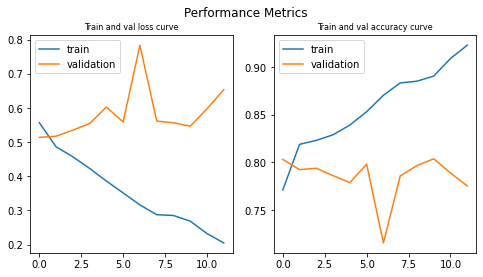

In [36]:
plot_history(history_model_2)

In [34]:
# Get the class-wise scores on the test data
y_pred_2 = model_2.predict(val_dataset)
threshold = 0.4
y_pred_binary_2 = (y_pred_2 > threshold).astype(int)
score_2 = model_2.evaluate(val_dataset, verbose = 1)
df_met_model_2 = metrics(y_val, y_pred_binary_2)
print(f'Test loss:{score_2[0]}\n Test accuracy:{score_2[1]}')
df_met_model_2

44/44 [==============================] - 1s 27ms/step - loss: 0.5140 - binary_accuracy: 0.8031
Test loss:0.5139632821083069
 Test accuracy:0.803102433681488


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Class,Sensitivity,Specificity,F1-score
0,No frac,0.000000,0.000000,0.000000
1,C1,0.070707,0.125000,0.090323
2,C2,0.005650,0.055556,0.010256
3,C3,0.000000,0.000000,0.000000
4,C4,0.000000,0.000000,0.000000
5,C5,0.000000,0.000000,0.000000
6,C6,0.015267,0.666667,0.029851
7,C7,0.030075,1.000000,0.058394
8,Thoracic,0.058480,0.169492,0.086957
